# This notebook aims to provide characteristics of the Covid-19 vaccinations proces 💉

- 🌍 Wow did the number of vaccinations shots change over time for the whole world?
- 📊 Wow did the number of vaccinations shots change over time per continent?
- 🏃‍ Which country has the best performance?
- 🏆 How far is each country from herd immunity?
- 🤝 Which vaccines are used in different countries?

## Setup

### Install & import libraries

In [1]:
%%capture 
!pip install pycountry_convert

import numpy as np 
import pandas as pd 
data = pd.read_csv("../input/covid-world-vaccination-progress/country_vaccinations.csv")

### Charts settings

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 12),
          'figure.titlesize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

### Remove data for countries without iso code (e.g. UK countries whose data is provided anyway under United Kingdom label)

In [3]:
not_iso_countries = data.country[data.iso_code.isnull()].unique()
data = data[~data.country.isin(not_iso_countries)]

# Total number of vaccinations
This chart presents how did the total number of given vaccination shots change over time. It makes to possible to judge the overall growth trend.

### Prepare data
1. Extract date, country, total_vaccinations
2. Fill data for missing dates by using last seen number of total_vaccinations
3. Sum total vaccinations from countries per day

In [4]:
#1
data_tv = data.loc[:,["date", "country", "total_vaccinations"]].dropna(subset=['total_vaccinations'])

#2
data_tv['date'] = pd.to_datetime(data_tv['date'])
data_tv = data_tv.groupby(['country'], as_index=False).apply(lambda x: x.set_index('date').resample('D').bfill())

#3
sum_over_dates = data_tv.reset_index().groupby("date").total_vaccinations.sum()

### Plot chart

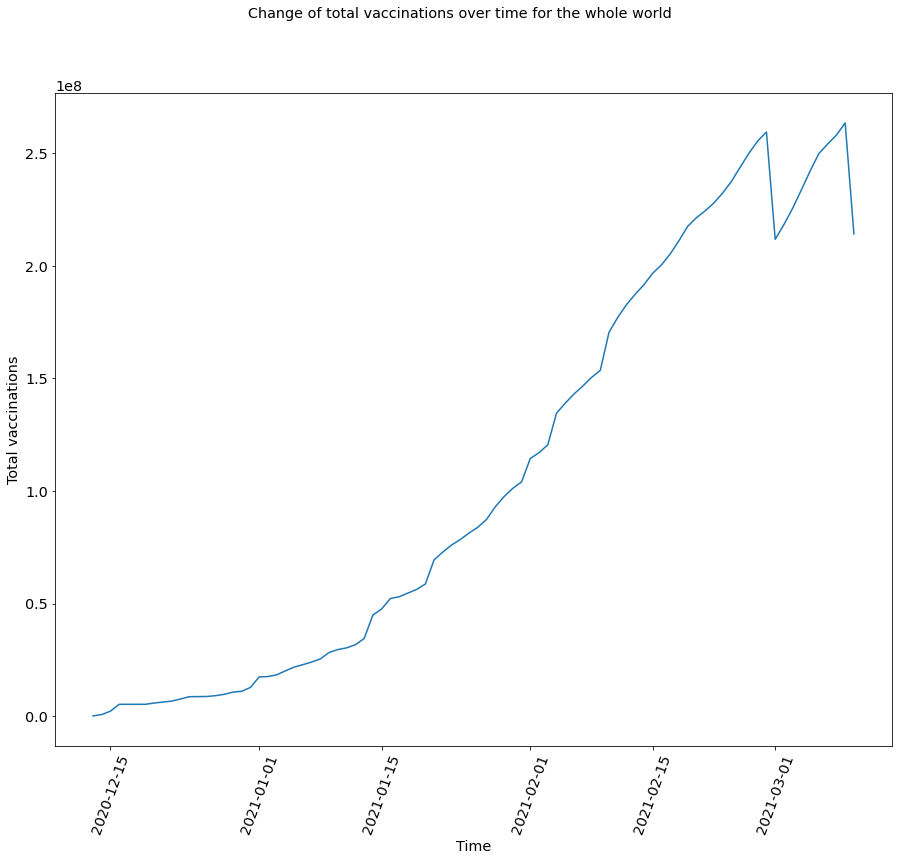

In [5]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Change of total vaccinations over time for the whole world")
plt.xlabel("Time")
plt.ylabel("Total vaccinations")
plt.xticks(rotation=70)
plt.plot(sum_over_dates)

# Total number of vaccinations per contintent
This chart presents how did the total number of given vaccination shots change over time for continents separatelym. It makes possible to compare the growth trend for continents.

### Prepare data
1. Check what continent does the country belong to.
2. Sum total vaccinations from countries per day for continent separately.

In [6]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

#1
continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Australia',
        'AF': 'Africa',
        'EU': 'Europe'
    }

def get_continent(country_name):
    try:
        return continents[country_alpha2_to_continent_code(country_name_to_country_alpha2(country_name))]
    except:
        if country_name == "Faeroe Islands":
            return "EU"
        elif country_name == "Saint Helena":
            return "EU"
        return None

data_tv["continent"] = data_tv.country.map(lambda x: get_continent(x))
print("Any continent code is null?: ", data_tv.continent.isnull().any())

#2
sum_over_dates_per_continent = data_tv.reset_index().groupby(["continent", "date"]).total_vaccinations.sum()

Any continent code is null?:  False


### Plot chart

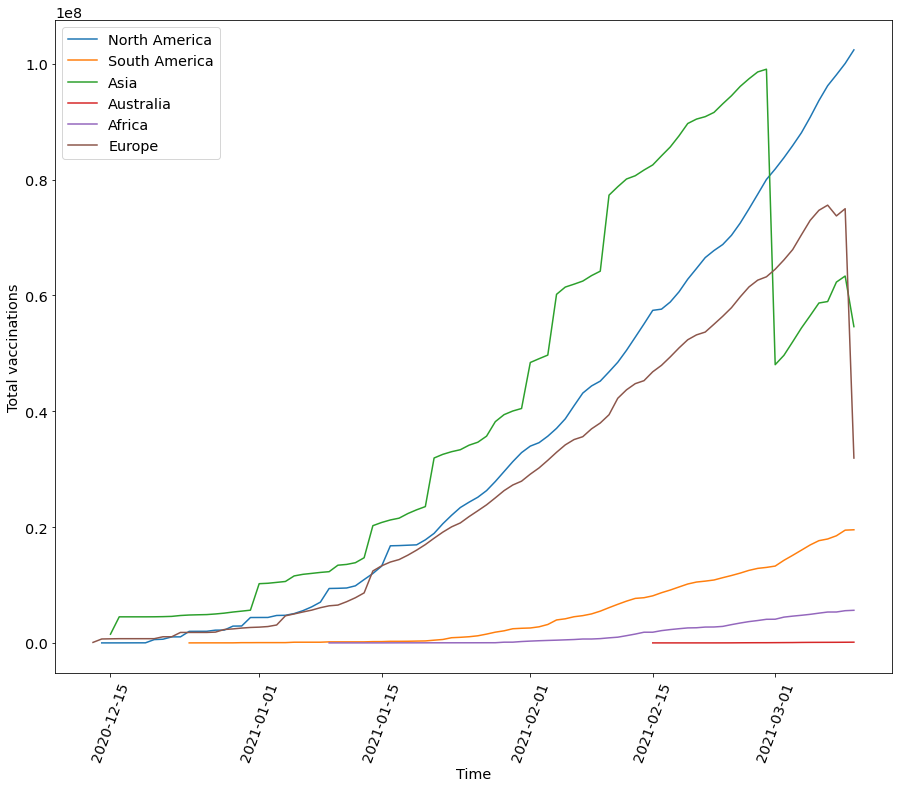

In [7]:
fig.suptitle("Change of total vaccinations over time per continent")
plt.xlabel("Time")
plt.ylabel("Total vaccinations")
plt.xticks(rotation=70)

for continent in continents.values():
    plt.plot(sum_over_dates_per_continent[continent], label=continent)
plt.legend()

# Compary countries' speed

### Prepare vaccination speed data
1. Extract country, iso_code and daily_vaccinations
2. For each country calculate the average daily vaccinations number

In [8]:
#1
data_speed = data.loc[:, ["country", "iso_code", "daily_vaccinations"]]

#2
data_speed = data_speed.groupby(["country"], as_index=False).agg({'daily_vaccinations': 'mean', 'iso_code': 'last'}).dropna(subset=["daily_vaccinations"])

### Prepare map data
1. Read world shape file
2. Remove Antarctica, exract iso code (ADM0_A3), map drawing data (geometry)

In [9]:
import geopandas as gpd

#1
full_data = gpd.read_file("../input/world-shapefiles/ne_10m_admin_0_countries.shp")

#2
geo_data = full_data.loc[(full_data.ADMIN!="Antarctica"), ["geometry", "ADM0_A3"]].copy()

### Join vaccination speed data and map data

In [10]:
data_speed.set_index("iso_code", inplace=True)
data_speed_map = geo_data.join(data_speed, on="ADM0_A3")

### Plot map

<AxesSubplot:title={'center':'Country speed'}>

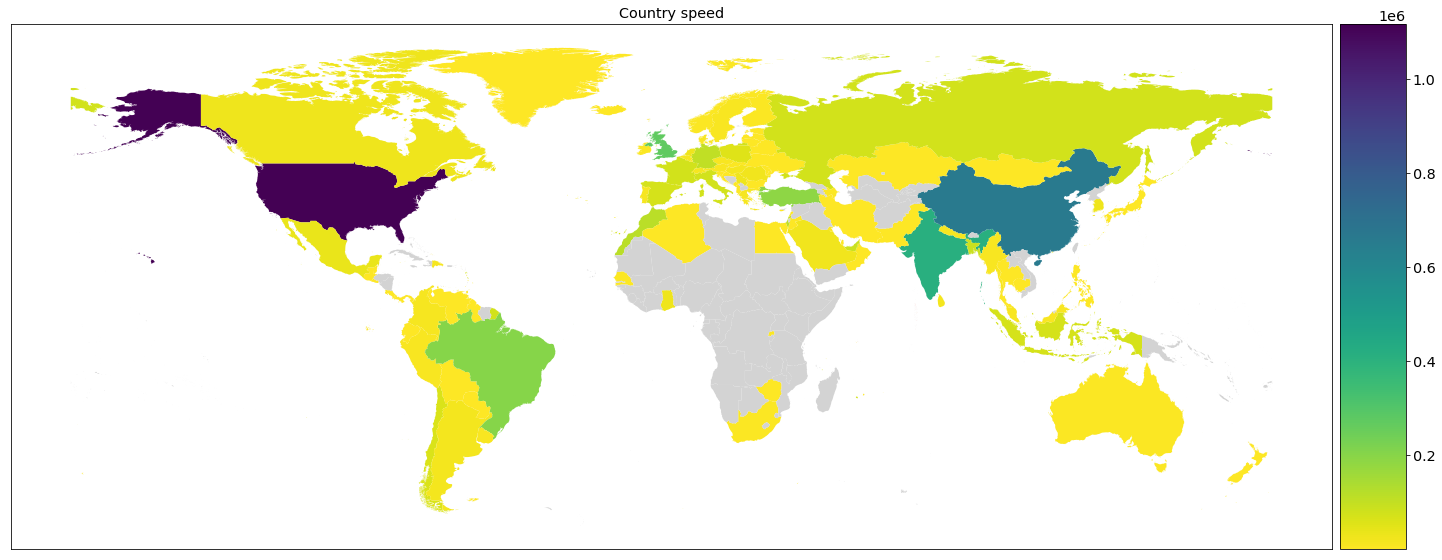

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(25,25))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_xticks([])
ax.set_yticks([])
ax.title.set_text("Country speed")
data_speed_map.plot(column='daily_vaccinations', 
            ax=ax, 
            cax=cax,
            legend=True, 
            cmap="viridis_r",
            missing_kwds={"color": "lightgrey", "label": "Missing values"}
            )

# How far from herd immunity are the contries?
This map presents what is the current percentage of people who got full vaccination. As a desired level 50% is chosen.

### Prepare vaccination data
1. Extract date, country, iso_code and people_fully_vaccinated_per_hundred
2. For each country leave the most current number of people_fully_vaccinated_per_hundred.

In [12]:
#1
data_hi = data.loc[:,["date", "country", "iso_code", "people_fully_vaccinated_per_hundred"]].fillna({"people_fully_vaccinated_per_hundred":0})

#2
data_hi = data_hi.groupby(["country"], as_index=False).last()

### Join vaccination and map data

In [13]:
data_hi.set_index("iso_code", inplace=True)
data_hi_map = geo_data.join(data_hi, on="ADM0_A3")

### Plot map

<AxesSubplot:title={'center':'People fully vaccinated per hundred'}>

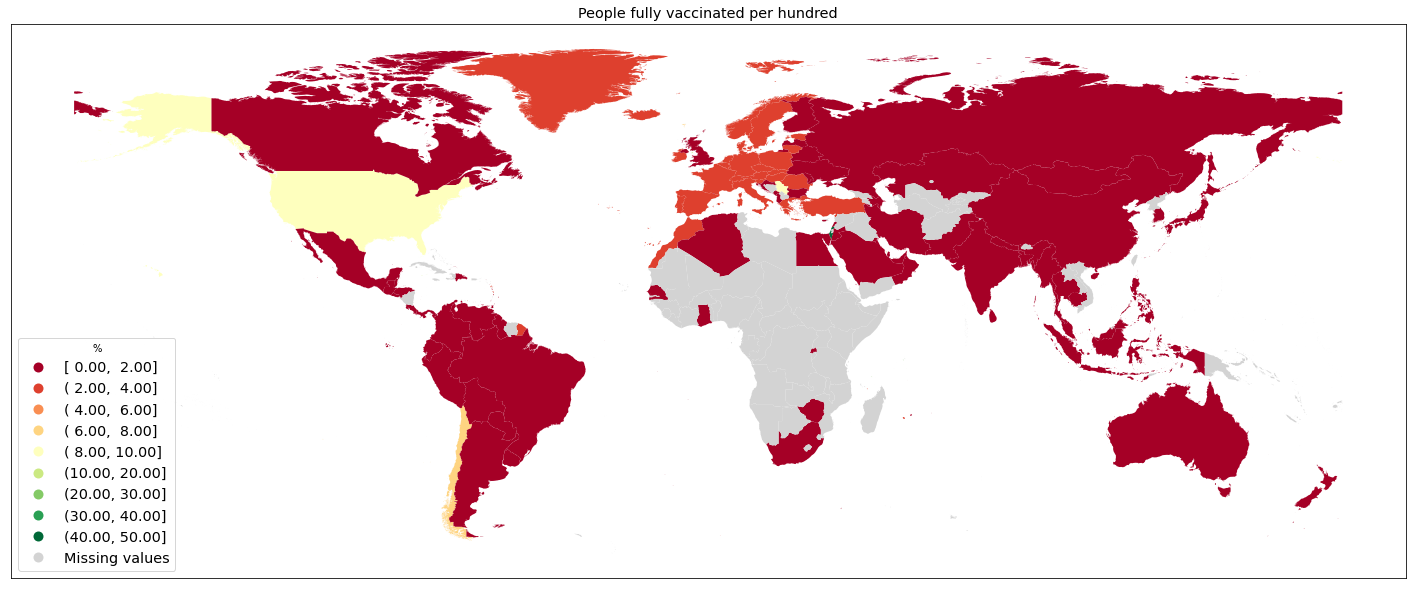

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(25,25))
ax.set_xticks([])
ax.set_yticks([])
ax.title.set_text("People fully vaccinated per hundred")
data_hi_map.plot(column='people_fully_vaccinated_per_hundred', 
            ax=ax, 
            legend=True, 
            cmap="RdYlGn",
            legend_kwds={'loc': 'lower left', 'title': "%"},
            missing_kwds={"color": "lightgrey", "label": "Missing values"},
            scheme='User_Defined',
            classification_kwds=dict(bins=[2,4,6,8,10,20,30,40,50]), 
            )


# What vaccine is used in which country?
This network shows how the vaccines are distributed among countries. This gives an idea about international relations.

### Prepare vaccines data
1. Read all vaccines names available in the dataset
2. Encode the information of vaccines used in each country as a boolean table

In [15]:
#1
vaccine_names = np.unique([*map(lambda x: x.strip(), np.hstack(data.vaccines.map(lambda vacc_list: vacc_list.split(",")).to_numpy()))])

#2
def encode_vaccine_usage(row):
    for vaccine_name in vaccine_names:
        row[vaccine_name] = True if vaccine_name in row.vaccines else False
    return row

data_vacc = data.loc[:,["iso_code", "country", "vaccines"]].groupby("country", as_index=False).last()
data_vacc = data_vacc.apply(encode_vaccine_usage, axis=1)

### Prepare network of *country* <-> *vaccine* connetions
1. Create graph.
2. Create colors palette
3. Create vaccines node
4. Create edges for vaccines used in different countries

In [16]:
import networkx as nx

#1
G = nx.Graph()

#2
colors = ["red", "green", "blue", "yellow", "brown", "violet", "orange", "grey", "orangered", "dodgerblue"]

#3
vaccine_colors = {}
for i, vaccine in enumerate(vaccine_names):
    vaccine_colors[vaccine] = colors[i]
    G.add_node(vaccine, color=colors[i], weight=5000, node_shape='d')

#4
for i, row in data_vacc.iterrows():
    for vaccine_name in vaccine_names:
        if row[vaccine_name]:
            G.add_node(row.country, weight=5)
            G.add_edge(row.country, vaccine_name, color=vaccine_colors[vaccine_name])

### Draw network

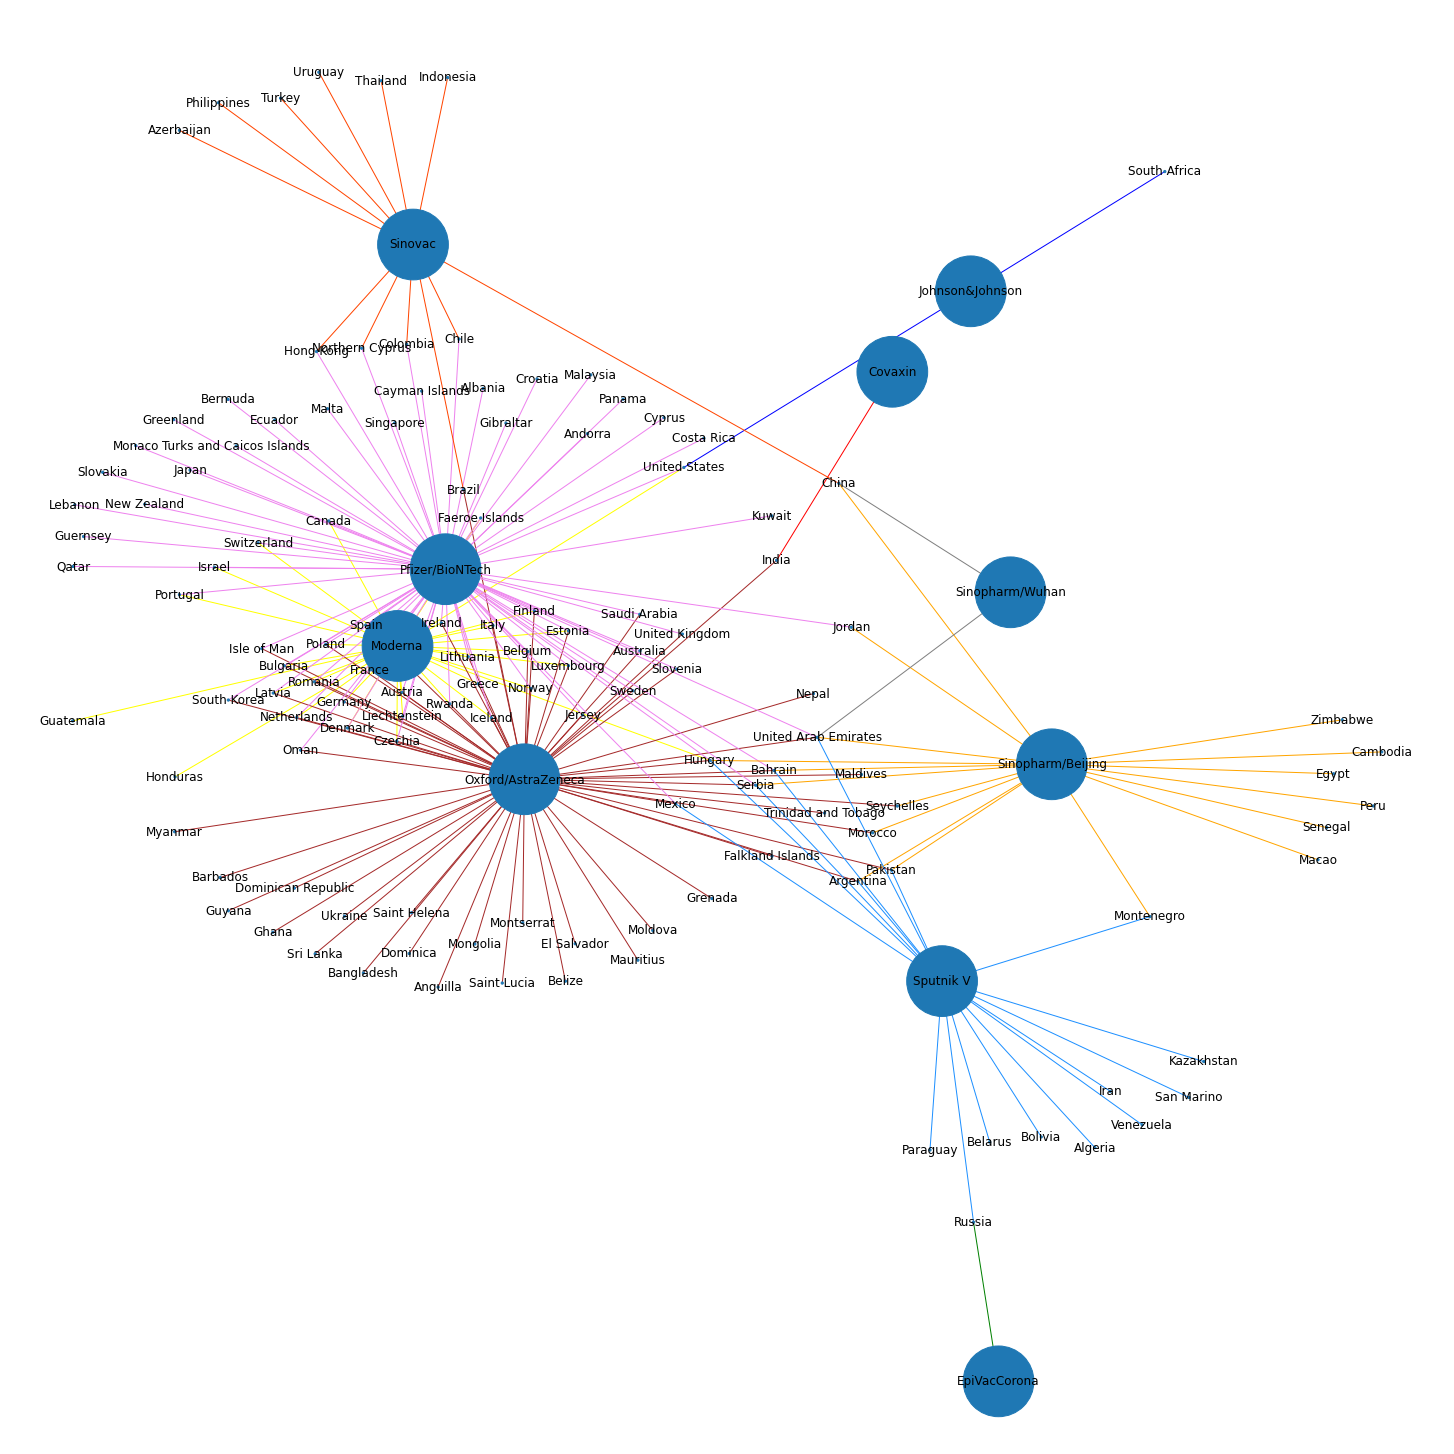

In [17]:
colors = nx.get_edge_attributes(G,'color').values()
weights = [w for w in nx.get_node_attributes(G,'weight').values()]
plt.figure(figsize=(20,20))
options = {
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
    'edge_color': colors,
    'node_size': weights,
   'font_size': 12
}

nx.draw(G, nx.spring_layout(G, seed=3), **options)
ax = plt.gca()
plt.show()

# Thank you for reading this notebook! Any advice and suggestions will be greatly appreciated 🙂